In [6]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


In [7]:
import math
import torch
from torch import nn


class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [11]:
import torchvision.models as models

class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = models.vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [8]:
import torchvision.models as models
from datetime import datetime
import torchvision

def train_model(
    generator,
    discriminator,
    train_loader,
    criterion_content,
    criterion_adversarial,
    optimizer_g,
    optimizer_d,
    num_epochs=5,
    device="cuda",
    content_weight=1.0,
):
    dirname = f"model_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    os.makedirs(dirname, exist_ok=True)
    generator.to(device)
    discriminator.to(device)
    generator.train()
    discriminator.train()

    vgg = models.vgg19(pretrained=True).features[:35].eval().to(device)
    for param in vgg.parameters():
        param.requires_grad = False

    for epoch in range(num_epochs):
        running_g_loss = 0.0
        running_d_loss = 0.0

        for i, (lr_images, hr_images) in enumerate(train_loader):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)
            batch_size = lr_images.size(0)

            real_labels = torch.full((batch_size, 1), 1, device=device)
            fake_labels = torch.full((batch_size, 1), 0, device=device)

            optimizer_d.zero_grad()
            real_output = discriminator(hr_images)
            d_loss_real = criterion_adversarial(real_output, real_labels)
            hr_fake = generator(lr_images)
            fake_output = discriminator(hr_fake.detach())
            d_loss_fake = criterion_adversarial(fake_output, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            optimizer_d.step()

            # Trening Generatora
            optimizer_g.zero_grad()
            hr_fake = generator(lr_images)
            fake_output = discriminator(hr_fake)
            g_loss_adv = criterion_adversarial(fake_output, real_labels)
            g_loss_content = criterion_content(hr_fake, hr_images)
            vgg_loss = criterion_content(vgg(hr_fake), vgg(hr_images))
            g_loss = g_loss_adv + content_weight * g_loss_content + 10.0 * vgg_loss
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=10.0)
            optimizer_g.step()

            running_d_loss += d_loss.item() if i % 2 == 0 else 0
            running_g_loss += g_loss.item()

            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], "
                      f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        
        epoch_d_loss = running_d_loss / (len(train_loader) // 2) if len(train_loader) % 2 == 0 else running_d_loss / ((len(train_loader) + 1) // 2)
        epoch_g_loss = running_g_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            torch.save(generator.state_dict(), f"{dirname}/generator_epoch_{epoch + 1}.pth")
            torch.save(discriminator.state_dict(), f"{dirname}/discriminator_epoch_{epoch + 1}.pth")
            with torch.no_grad():
                fake_images = generator(lr_images[:4])
                torchvision.utils.save_image(fake_images, f"{dirname}/output_epoch_{epoch+1}.png", normalize=True)

    return generator, discriminator

In [9]:

class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, transform_hr=None, transform_lr=None):
        """
        Inicjalizuje dataset.
        :param hr_dir: Ścieżka do folderu z obrazami wysokiej rozdzielczości (HR).
        :param transform_hr: Transformacje do obrazów wysokiej rozdzielczości.
        :param transform_lr: Transformacje do obrazów niskiej rozdzielczości.
        """
        self.hr_dir = hr_dir
        # Lista plików w katalogu HR (teraz nie ładujemy ich od razu do pamięci)
        self.image_files = sorted(
            [f for f in os.listdir(hr_dir) if os.path.isfile(os.path.join(hr_dir, f))][
                0:32
            ]
        )  # Ograniczenie liczby obrazów do 100
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr

    def __len__(self):
        """
        Zwraca liczbę dostępnych próbek w zbiorze danych.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Ładuje i przetwarza obraz na żądanie (lazy loading).
        :param idx: Indeks próbki.
        :return: Obraz w niskiej rozdzielczości i wysokiej rozdzielczości.
        """
        img_name = self.image_files[idx]
        img_path = os.path.join(self.hr_dir, img_name)

        # Lazy loading: Wczytanie obrazu HR tylko wtedy, gdy jest potrzebny
        hr_image = Image.open(img_path).convert("RGB")
       
        # Tworzymy obraz LR poprzez zmianę rozmiaru HR (pomijamy wcześniejsze wczytanie LR)
        lr_image = transforms.Resize((64, 64))(hr_image)

        # Transformacje obrazu HR (jeśli zostały podane)
        if self.transform_hr:
            hr_image = self.transform_hr(hr_image)

        # Transformacje obrazu LR (jeśli zostały podane)
        if self.transform_lr:
            lr_image = self.transform_lr(lr_image)

        return lr_image, hr_image

In [10]:
batch_size = 16
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicjalizacja modeli
generator = Generator(scale_factor=4)
discriminator = Discriminator()

# Optimizery
optimizer_g = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-6)

# Funkcje straty
criterion_content = nn.MSELoss()
criterion_adversarial = nn.BCELoss()

# Dane (przykład z CIFAR-10, ale powinieneś użyć swojego datasetu)
transform_lr = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
transform_hr = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Zakładam, że masz dataset z parami (low_res, high_res)
dataset = SuperResolutionDataset(
    hr_dir="images_256", transform_hr=transform_hr, transform_lr=transform_lr
)
# W rzeczywistym przypadku potrzebujesz drugiego datasetu/transformacji dla HR
train_loader = DataLoader(dataset, num_workers=4, batch_size=batch_size, shuffle=True)

# Trening
generator, discriminator = train_model(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    criterion_content=criterion_content,
    criterion_adversarial=criterion_adversarial,
    optimizer_g=optimizer_g,
    optimizer_d=optimizer_d,
    num_epochs=num_epochs,
    device=device,
    content_weight=0.01,
)

/home/irek/Development/SIGK/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/irek/Development/SIGK/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ValueError: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])) is deprecated. Please ensure they have the same size.

In [ ]:
from matplotlib import pyplot as plt


def visualize_results(model, test_image_path, device="cuda"):
    model.eval()
    model.to(device)

    # Wczytanie obrazu testowego
    test_image = Image.open(test_image_path).convert("RGB")
    test_transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )

    lr_image = test_transform(test_image).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_image = model(lr_image)

    # Przywrócenie danych obrazu do zakresu [0,1]
    sr_image = (sr_image + 1) / 2.0
    lr_image = (lr_image + 1) / 2.0

    # Konwersja do formatu numpy do wyświetlenia
    sr_image = sr_image.squeeze().permute(1, 2, 0).cpu().numpy()
    lr_image = lr_image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Wczytanie oryginalnego obrazu o wysokiej rozdzielczości do porównania
    hr_image = transforms.Resize((256, 256))(test_image)
    hr_image = transforms.ToTensor()(hr_image).permute(1, 2, 0).numpy()

    # Wyświetlenie obrazów
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title("Niska rozdzielczość (64x64)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(sr_image)
    plt.title("Upscaling przez sieć (256x256)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title("Oryginalna wysoka rozdzielczość (256x256)")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig("super_resolution_results.png")
    plt.show()

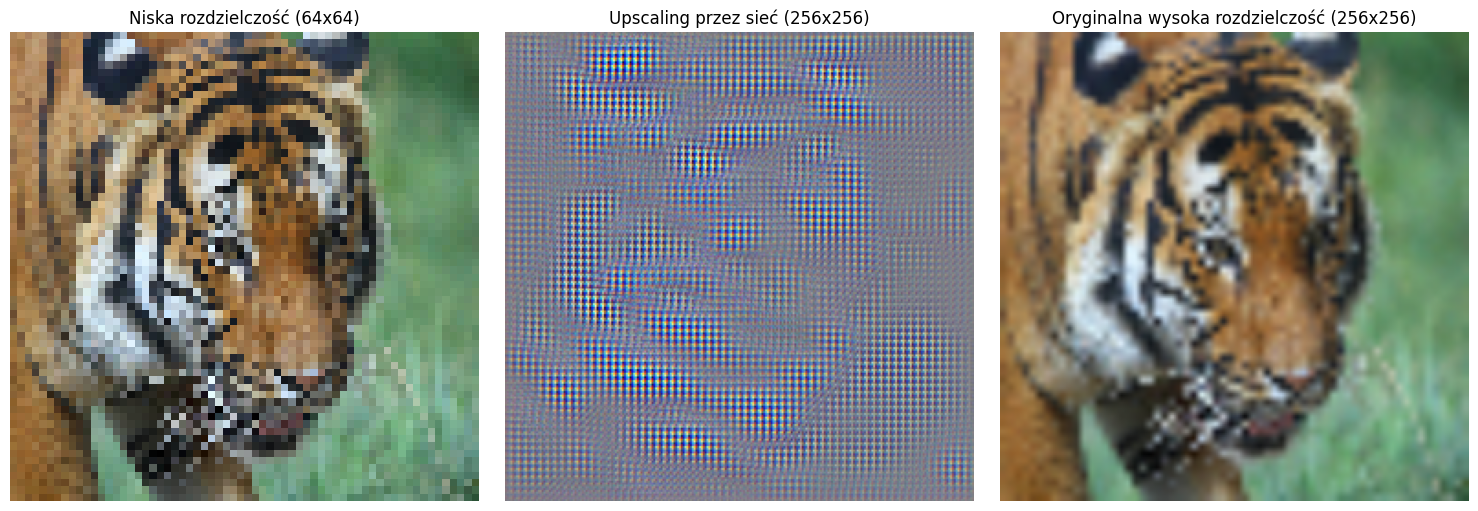

In [ ]:
# Testowanie modelu na przykładowym obrazie
test_image_path = "images_64/0010.png"
visualize_results(generator, test_image_path, device)